<a href="https://www.kaggle.com/code/zulqarnain11/x-ray-vision-cnn-for-lung-diseases?scriptVersionId=267726515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ============================================================
# 🩺 Deep Learning Classifier for Normal, Pneumonia & Tuberculosis X-Rays
# ============================================================

# ✅ Author: Zulqarnain
# ✅ Framework: TensorFlow / Keras
# ✅ Dataset: https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset
# ✅ Purpose: Classify chest X-rays into Normal, Pneumonia, and Tuberculosis
# ============================================================


# ---------------------------
# 1️⃣ Import Libraries
# ---------------------------

In [1]:
import kagglehub
import tensorflow as tf
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

2025-10-13 10:54:22.508033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760352862.678704      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760352862.736221      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ---------------------------
# 2️⃣ Load Dataset
# ---------------------------


In [2]:
path = kagglehub.dataset_download("muhammadrehan00/chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-dataset


In [3]:
os.listdir(path)

['data.yaml', 'val', 'test', 'train']

In [4]:
train_dir=os.path.join(path,'train')
test_dir=os.path.join(path,'test')
valdir=os.path.join(path,'val')

# ---------------------------
# 3️⃣ Create Image Datasets
# ---------------------------


In [5]:
train_ds =image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)
test_ds=image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)
val_ds=image_dataset_from_directory(
    valdir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)


Found 20450 files belonging to 3 classes.


I0000 00:00:1760352909.031006      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2569 files belonging to 3 classes.
Found 2534 files belonging to 3 classes.


In [6]:
class_names=train_ds.class_names
print(class_names)

['normal', 'pneumonia', 'tuberculosis']


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


# ---------------------------
# 4️⃣ Convert to Grayscale
# ---------------------------


In [8]:
#reshape to grayscale
train_ds=train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
test_ds=test_ds.map(lambda x,y: (tf.image.rgb_to_grayscale(x),y))
val_ds=val_ds.map(lambda x,y: (tf.image.rgb_to_grayscale(x),y))

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 1)
(32,)


In [10]:
len(train_ds)

640

# ---------------------------
# 5️⃣ Normalize & Augment
# ---------------------------


In [11]:
def resize_and_rescale():
    return tf.keras.Sequential([
        tf.keras.layers.Resizing(256, 256),
        tf.keras.layers.Rescaling(1./255)
    ])


In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [13]:
train_ds=train_ds.map(lambda x,y: (resize_and_rescale()(x),y))
test_ds=test_ds.map(lambda x,y: (resize_and_rescale()(x),y))
val_ds=val_ds.map(lambda x,y: (resize_and_rescale()(x),y))

# ---------------------------
# 6️⃣ Compute Class Weights
# ---------------------------


In [14]:
labels = []

for x, y in train_ds:
    labels.extend(y.numpy())  # Convert tensors to NumPy arrays and add to list

labels = np.array(labels)
unique, counts = np.unique(labels, return_counts=True)

for i, c in zip(unique, counts):
    print(f"{class_names[i]}: {c} images")


normal: 7263 images
pneumonia: 4674 images
tuberculosis: 8513 images


In [15]:
# Extract all labels as NumPy integers
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())  # convert tensors to numpy and flatten

# Convert to NumPy array
all_labels = np.array(all_labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convert to dictionary for Keras
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.9385469732433797, 1: 1.4584224789616318, 2: 0.8007361290575199}


In [16]:
autotune=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=autotune)
test_ds=test_ds.cache().prefetch(buffer_size=autotune)
val_ds=val_ds.cache().prefetch(buffer_size=autotune)

# ---------------------------
# 7️⃣ Model Architecture
# ---------------------------


In [17]:
model=Sequential([
    data_augmentation,
    Conv2D(32,(3,3),activation='relu',input_shape=(256,256,1)),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.01),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(len(class_names),activation='softmax')
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# ---------------------------
# 8️⃣ Training
# ---------------------------


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_ds, validation_data=val_ds, epochs=30,
          callbacks=[early_stop], class_weight=class_weights)



Epoch 1/30


E0000 00:00:1760353112.024924      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1760353115.245730      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


640/640 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.6096 - loss: 0.7520 - val_accuracy: 0.7096 - val_loss: 0.5805
Epoch 2/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.7069 - loss: 0.5553 - val_accuracy: 0.7151 - val_loss: 0.5259
Epoch 3/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7148 - loss: 0.5181 - val_accuracy: 0.7269 - val_loss: 0.5003
Epoch 4/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7295 - loss: 0.4927 - val_accuracy: 0.7167 - val_loss: 0.5054
Epoch 5/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7341 - loss: 0.4762 - val_accuracy: 0.7289 - val_loss: 0.4930
Epoch 6/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7382 - loss: 0.4675 - val_accuracy: 0.7447 - val_loss: 0.4752
Epoch 7/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7396 - loss: 0.4527 - val_accuracy: 0.7435 - val_loss: 0.4657
Epoch 8/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.7434 - loss: 0.4467 - val_accur

# ---------------------------
# 9️⃣ Evaluation
# ---------------------------


In [19]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.7552 - loss: 0.4544

✅ Test Accuracy: 0.7555
✅ Test Loss: 0.4518


# ---------------------------
# 🔟 Confusion Matrix
# ---------------------------


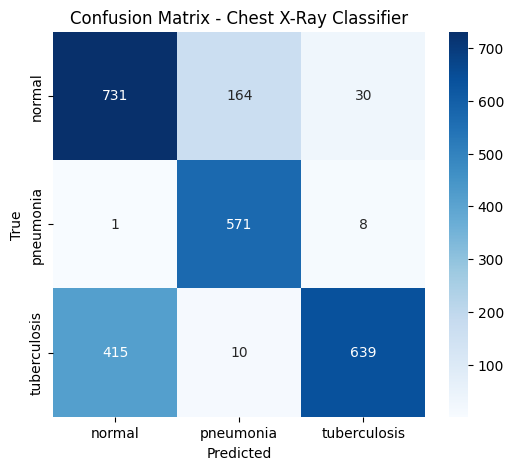


Classification Report:

              precision    recall  f1-score   support

      normal       0.64      0.79      0.71       925
   pneumonia       0.77      0.98      0.86       580
tuberculosis       0.94      0.60      0.73      1064

    accuracy                           0.76      2569
   macro avg       0.78      0.79      0.77      2569
weighted avg       0.79      0.76      0.75      2569



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images,verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 2️⃣ Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3️⃣ Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Chest X-Ray Classifier")
plt.show()
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
